# CNN Tutorial: From LeNet to AlexNet

**Deep Learning - University of Vermont**

Welcome! In this session, we journey from the origins of computer vision to the deep learning revolution.

## In this session, we will learn:

1.  **The Intuition**: We'll break down what convolution, pooling, and stride actually mean.
2.   **Building Models**: We will construct a CNN.
3.  **The Classics**: Implement **LeNet-5** (1998) and **AlexNet** (2012).
4.  **Visualization**: Peek inside the network to see **Feature Maps** detecting edges and shapes.
5.  **Comparison**: Compare **Accuracy**, **Parameters**, and **Speed** across all architectures.
6.  **Interactive Exercises**: Hands-on challenges to build and refine your own CNNs.

---
*Let's get started!*

## 0. Setup and Utilities

Let's start by importing the necessary libraries. We'll be using PyTorch for building our models and Matplotlib for visualization.

In [24]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time

In [25]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


### Now, let's build a reusable training function. Instead of rewriting the training code for every model (MLP, CNN, LeNet, AlexNet), we will define a single function called `train_model` that handles the training and validation for us.

In [26]:
def train_model(model, train_loader, test_loader, epochs=5, lr=0.01, name="Model"):
    """
    Generic training loop with validation.
    """
    # Move the model to the configured device (GPU or CPU)
    model = model.to(device)
    
    # Define our loss function (CrossEntropy is standard for multi-class classification)
    criterion = nn.CrossEntropyLoss()
    
    # Define the optimizer. We use SGD with momentum to help the model converge faster.
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9) 
    
    print(f"\nTraining {name} for {epochs} epochs...")
    start_time = time.time()
    
    # Variables to store the final metrics
    final_val_acc = 0
    final_val_loss = 0
    
    for epoch in range(epochs):
        # --- Training Phase ---
        # Set the model to training mode (enables Dropout and BatchNorm)
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            # Move data to the same device as the model
            images, labels = images.to(device), labels.to(device)
            
            # 1. Clear the gradients from the previous step
            optimizer.zero_grad()
            
            # 2. Forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            
            # 3. Calculate the loss
            loss = criterion(outputs, labels)
            
            # 4. Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # 5. Perform a single optimization step (parameter update)
            optimizer.step()
            
            running_loss += loss.item()
        
        # Calculate average training loss for the epoch
        train_loss = running_loss / len(train_loader)
        
        # --- Validation Phase ---
        # Set the model to evaluation mode (disables Dropout and BatchNorm)
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        # Disable gradient calculation to save memory and speed up computation
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # Calculate average validation metrics
        final_val_loss = val_loss / len(test_loader)
        final_val_acc = 100 * correct / total
        
        print(f"  Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {final_val_loss:.4f} | Val Acc: {final_val_acc:.2f}%")
            
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"{name} - Final Accuracy: {final_val_acc:.2f}%, Time: {duration:.2f}s")
    return final_val_acc, final_val_loss, duration

Finally, we'll create a dictionary to keep track of our results so we can compare the models later.

In [27]:
results = {}

In [28]:
# ==========================================
# Data Preparation
# ==========================================
# Standard transform for MLP, SimpleCNN, LeNet (28x28 input)
transform = transforms.Compose([transforms.ToTensor()])

train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Batch size of 256 is good for GPU utilization
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

print("Data loaded successfully.")

Data loaded successfully.


## 2. The Convolution Operation: A Simple Analogy

Imagine you are looking for a specific feature in an image, like a vertical edge or a curve. Instead of looking at the whole image at once, you use a small "flashlight."

1.  **The Filter (Kernel)**: Think of this as your flashlight beam (e.g., 3x3 pixels). It has a specific pattern it's looking for.
2.  **Convolution (Sliding)**: You slide this flashlight over every part of the image, from top-left to bottom-right.
3.  **Activation**: At each spot, you check: "Does the pattern under my flashlight match what I'm looking for?"
    *   If **YES**: You get a strong signal (high number).
    *   If **NO**: You get a weak signal or zero.

### Why is this better than an MLP?
*   **Spatial Awareness**: It understands that pixels close together form shapes. MLPs just see a long list of unrelated numbers.
*   **Translation Invariance**: If a cat is in the top-left or bottom-right, the "cat-detecting flashlight" will find it regardless of its position.

### Key Terms to Remember:
*   **Stride**: How many pixels you move the flashlight at each step. Stride 1 = move 1 pixel. Stride 2 = skip 1 pixel (shrinks the output).
*   **Padding**: Adding a border of zeros around the image so the flashlight can reach the very edges without shrinking the image.

## 2. Parameter Calculation Practice

Understanding model size is crucial.

**Formulas:**
*   **Conv Layer**: $(K \times K \times C_{in} + 1) \times C_{out}$ (where $+1$ is for bias)
*   **FC Layer**: $(N_{in} + 1) \times N_{out}$
*   **Pooling**: 0 parameters



## 3. The Multi-Layer Perceptron (MLP)

To see why CNNs are so powerful, we first need to build a standard MLP. 

**The Problem with MLPs for Images:**
MLPs require us to "flatten" the 2D image (28x28) into a single 1D vector (784 numbers). This completely destroys the spatial structure of the image. The model has to work much harder to learn that pixel (1,1) is actually next to pixel (1,2).

Let's define and train our MLP baseline now.

In [29]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Flatten converts the 28x28 image into a 784-long 1D vector
        self.flatten = nn.Flatten()
        
        # First hidden layer: 784 inputs -> 256 neurons
        # This layer alone has (784+1)*256 = 200,960 parameters!
        self.fc1 = nn.Linear(28*28, 256)
        self.relu = nn.ReLU()
        
        # Output layer: 256 inputs -> 10 clothing classes
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.flatten(x)        # [batch, 1, 28, 28] -> [batch, 784]
        x = self.relu(self.fc1(x)) # [batch, 256]
        x = self.fc2(x)            # [batch, 10]
        return x

# Initialize and train the baseline MLP
mlp = MLP()
acc, loss, t = train_model(mlp, train_loader, test_loader, epochs=5, name="MLP")
results['MLP'] = {'acc': acc, 'loss': loss, 'time': t, 'params': sum(p.numel() for p in mlp.parameters())}


Training MLP for 5 epochs...
  Epoch [1/5] | Train Loss: 0.9055 | Val Loss: 0.5943 | Val Acc: 79.52%
  Epoch [2/5] | Train Loss: 0.5323 | Val Loss: 0.5362 | Val Acc: 81.08%
  Epoch [3/5] | Train Loss: 0.4777 | Val Loss: 0.4855 | Val Acc: 82.95%
  Epoch [4/5] | Train Loss: 0.4515 | Val Loss: 0.4738 | Val Acc: 82.78%
  Epoch [5/5] | Train Loss: 0.4321 | Val Loss: 0.4697 | Val Acc: 83.76%
MLP - Final Accuracy: 83.76%, Time: 32.38s


## 4. Building Our First CNN

Now, let's build a model that actually understands space! We'll use convolutional layers to extract features and pooling layers to simplify the information.

**Our Architecture Strategy:**
1.  **Block 1 (The Edge Detector)**: Uses 32 filters to find basic lines and textures.
2.  **Block 2 (The Shape Detector)**: Uses 64 filters to combine those lines into more complex shapes.
3.  **The Classifier**: Takes those high-level shapes and makes a final guess (T-shirt? Boot? Dress?).

In [30]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # Block 1: Low-level feature detection (Edges, Textures)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # Normalizes activations for faster training
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2) # 28x28 -> 14x14
        
        # Block 2: Mid-level feature detection (Shapes, Parts)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2) # 14x14 -> 7x7
        
        # Classifier: Decision making based on extracted features
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 600)
        self.drop = nn.Dropout(0.25) # Regularization to prevent overfitting
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        # Pass through convolutional blocks
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        
        # Flatten and classify
        x = self.flatten(x)
        x = self.drop(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Initialize and train our first CNN
cnn = SimpleCNN()
acc, loss, t = train_model(cnn, train_loader, test_loader, epochs=5, name="Simple CNN")
results['Simple CNN'] = {'acc': acc, 'loss': loss, 'time': t, 'params': sum(p.numel() for p in cnn.parameters())}


Training Simple CNN for 5 epochs...
  Epoch [1/5] | Train Loss: 0.4848 | Val Loss: 0.3599 | Val Acc: 86.96%
  Epoch [2/5] | Train Loss: 0.3079 | Val Loss: 0.3340 | Val Acc: 87.05%
  Epoch [3/5] | Train Loss: 0.2691 | Val Loss: 0.3069 | Val Acc: 88.73%
  Epoch [4/5] | Train Loss: 0.2482 | Val Loss: 0.2691 | Val Acc: 90.54%
  Epoch [5/5] | Train Loss: 0.2258 | Val Loss: 0.2924 | Val Acc: 89.20%
Simple CNN - Final Accuracy: 89.20%, Time: 38.50s


## 5. LeNet-5: The Grandfather of CNNs

**Historical Context:**
In 1998, Yann LeCun and his colleagues published a landmark paper introducing **LeNet-5**. This was the first time a convolutional neural network was successfully applied to a large-scale problem: recognizing handwritten digits for the US Postal Service.

**Why it was revolutionary:**
*   **Weight Sharing**: Instead of every pixel having its own weight (like an MLP), filters are reused across the image.
*   **Hierarchical Features**: It learned simple features (edges) in early layers and complex features (shapes) in later layers.

**LeNet-5 Structure:**
```
Input (1×28×28)
  ↓
Conv1: 5×5, 6 filters → (6×28×28)
  ↓ Sigmoid
AvgPool: 2×2 → (6×14×14)
  ↓
Conv2: 5×5, 16 filters → (16×10×10)
  ↓ Sigmoid
AvgPool: 2×2 → (16×5×5)
  ↓ Flatten
FC1: 120 units
  ↓ Sigmoid
FC2: 84 units
  ↓ Sigmoid
FC3: 10 units (output)
```

**Architecture Breakdown:**
1.  **C1 (Conv)**: 6 filters of size 5x5. Why 6? Because memory was expensive in 1998!
2.  **S2 (Subsampling)**: Average pooling to reduce resolution.
3.  **C3 (Conv)**: 16 filters. This layer combines the 6 feature maps from C1 into 16 new patterns.
4.  **S4 (Subsampling)**: Another pooling layer.
5.  **F6 (Fully Connected)**: 84 neurons (chosen to match the size of a 7x12 bitmap representation of characters).

We'll use a modernized version with **ReLU** activations instead of the original Sigmoid to make it train faster.

In [31]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        # --- Feature Extractor ---
        # Layer 1: Convolutional. Input: 1 channel (grayscale). Output: 6 filters.
        # We use padding=2 to make the 28x28 image behave like the 32x32 image LeNet was designed for.
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU() # Modern update: ReLU instead of Sigmoid
        # Pooling: Reduces 28x28 to 14x14. Keeps the strongest signals.
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Layer 2: Convolutional. Input: 6 channels. Output: 16 filters.
        # Kernel size 5x5 with no padding reduces the size: 14x14 -> 10x10.
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.relu2 = nn.ReLU()
        # Pooling: Reduces 10x10 to 5x5.
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # --- Classifier ---
        self.flatten = nn.Flatten() # Flatten 16 maps of 5x5 into a 400-element vector
        
        # Fully Connected Layer 1: 400 inputs -> 120 outputs
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3 = nn.ReLU()
        
        # Fully Connected Layer 2: 120 inputs -> 84 outputs
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        
        # Output Layer: 84 inputs -> 10 outputs (one for each clothing class)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Pass through the first block
        x = self.pool1(self.relu1(self.conv1(x)))
        # Pass through the second block
        x = self.pool2(self.relu2(self.conv2(x)))
        # Flatten for the dense layers
        x = self.flatten(x)
        # Final classification
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
lenet = LeNet()

# Train the model using our utility function
acc, loss, t = train_model(lenet, train_loader, test_loader, epochs=5, name="LeNet")

# Store the results for the final comparison
results['LeNet'] = {'acc': acc, 'loss': loss, 'time': t, 'params': sum(p.numel() for p in lenet.parameters())}


Training LeNet for 5 epochs...
  Epoch [1/5] | Train Loss: 1.8137 | Val Loss: 0.7898 | Val Acc: 69.45%
  Epoch [2/5] | Train Loss: 0.7078 | Val Loss: 0.6635 | Val Acc: 74.41%
  Epoch [3/5] | Train Loss: 0.5877 | Val Loss: 0.5500 | Val Acc: 78.94%
  Epoch [4/5] | Train Loss: 0.5167 | Val Loss: 0.5035 | Val Acc: 81.35%
  Epoch [5/5] | Train Loss: 0.4765 | Val Loss: 0.4819 | Val Acc: 82.09%
LeNet - Final Accuracy: 82.09%, Time: 33.85s


### 📑 Exercise 1: The "Original" LeNet Challenge

In the original 1998 paper, Yann LeCun used **Sigmoid** activation functions instead of **ReLU**. 

**Your Task:**
1.  Create a new class called `LeNetSigmoid`.
2.  Copy the code from the `LeNet` class above.
3.  Replace all `nn.ReLU()` calls with `nn.Sigmoid()`.
4.  Train it for 5 epochs and observe the difference in **Validation Accuracy** and **Training Loss**.

**Question to think about:** Why do you think modern researchers prefer ReLU over Sigmoid?

In [32]:
class LeNetSigmoid(nn.Module):
    def __init__(self):
        super(LeNetSigmoid, self).__init__()
        # TODO: Define your layers here using nn.Sigmoid()
        pass

    def forward(self, x):
        # TODO: Implement the forward pass
        return x

# lenet_sigmoid = LeNetSigmoid()
# train_model(lenet_sigmoid, train_loader, test_loader, epochs=5, name="LeNet-Sigmoid")

## Peeking Inside: Visualizing Feature Maps

Have you ever wondered what a neural network actually "sees"? 

In this section, we'll take a sample image and pass it through the first layer of our models. We'll visualize the output of the filters to see how they detect edges and patterns.

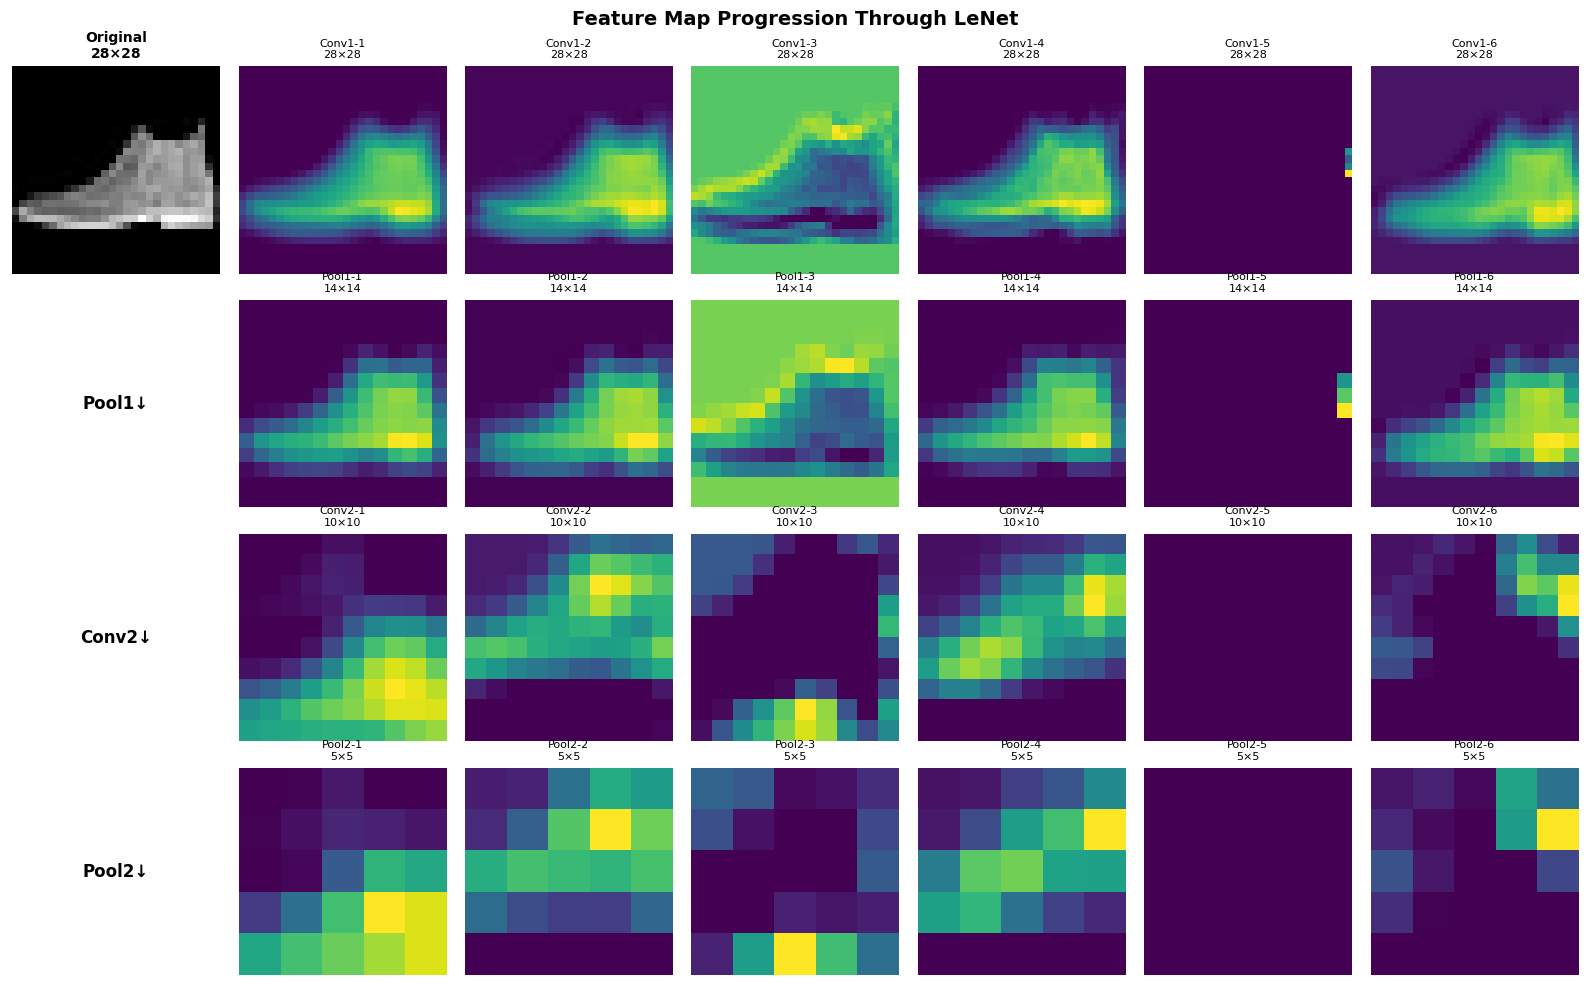


💡 Hierarchical Feature Learning:
   Layer 1 (Conv1): Detects edges, simple patterns (28×28)
   Layer 2 (Pool1): Downsamples, keeps important features (14×14)
   Layer 3 (Conv2): Combines edges into shapes, textures (10×10)
   Layer 4 (Pool2): Further abstraction (5×5)

   Notice: Spatial size ↓, but semantic meaning ↑


In [33]:
# Get a test image
test_images, test_labels = next(iter(test_loader))
test_img = test_images[0:1].to(device)  # Take first image

# Extract feature maps from each layer of LeNet
lenet.eval()
with torch.no_grad():
    # After first conv + activation
    x1 = lenet.relu1(lenet.conv1(test_img))
    # After first pooling
    x2 = lenet.pool1(x1)
    # After second conv + activation
    x3 = lenet.relu2(lenet.conv2(x2))
    # After second pooling
    x4 = lenet.pool2(x3)

# Visualize
fig = plt.figure(figsize=(16, 10))

# Original image
ax = plt.subplot(4, 7, 1)
ax.imshow(test_images[0].squeeze(), cmap='gray')
ax.set_title('Original\n28×28', fontsize=10, fontweight='bold')
ax.axis('off')

# First conv layer (6 feature maps at 28×28)
for i in range(6):
    ax = plt.subplot(4, 7, i + 2)
    ax.imshow(x1[0, i].cpu(), cmap='viridis')
    ax.set_title(f'Conv1-{i+1}\n28×28', fontsize=8)
    ax.axis('off')

# After first pooling (6 feature maps at 14×14)
ax = plt.subplot(4, 7, 8)
ax.text(0.5, 0.5, 'Pool1↓', ha='center', va='center', fontsize=12, fontweight='bold')
ax.axis('off')

for i in range(6):
    ax = plt.subplot(4, 7, i + 9)
    ax.imshow(x2[0, i].cpu(), cmap='viridis')
    ax.set_title(f'Pool1-{i+1}\n14×14', fontsize=8)
    ax.axis('off')

# Second conv layer (show first 6 of 16 feature maps at 10×10)
ax = plt.subplot(4, 7, 15)
ax.text(0.5, 0.5, 'Conv2↓', ha='center', va='center', fontsize=12, fontweight='bold')
ax.axis('off')

for i in range(6):
    ax = plt.subplot(4, 7, i + 16)
    ax.imshow(x3[0, i].cpu(), cmap='viridis')
    ax.set_title(f'Conv2-{i+1}\n10×10', fontsize=8)
    ax.axis('off')

# After second pooling (show first 6 of 16 feature maps at 5×5)
ax = plt.subplot(4, 7, 22)
ax.text(0.5, 0.5, 'Pool2↓', ha='center', va='center', fontsize=12, fontweight='bold')
ax.axis('off')

for i in range(6):
    ax = plt.subplot(4, 7, i + 23)
    ax.imshow(x4[0, i].cpu(), cmap='viridis')
    ax.set_title(f'Pool2-{i+1}\n5×5', fontsize=8)
    ax.axis('off')

plt.suptitle('Feature Map Progression Through LeNet', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Hierarchical Feature Learning:")
print("   Layer 1 (Conv1): Detects edges, simple patterns (28×28)")
print("   Layer 2 (Pool1): Downsamples, keeps important features (14×14)")
print("   Layer 3 (Conv2): Combines edges into shapes, textures (10×10)")
print("   Layer 4 (Pool2): Further abstraction (5×5)")
print("\n   Notice: Spatial size ↓, but semantic meaning ↑")

## 6. AlexNet: The Deep Learning Revolution

###  Historical Context

> "AlexNet, which employed an 8-layer CNN, won the ImageNet Large Scale Visual Recognition Challenge 2012 by a large margin. This network showed, for the first time, that the features obtained by learning can transcend manually-designed features, breaking the previous paradigm in computer vision."


**What made it a game-changer?**
1.  **GPU Training**: It was one of the first major models trained on GPUs (two NVIDIA GTX 580s!), allowing it to scale to 60 million parameters.
2.  **ReLU Activation**: It proved that ReLU was far superior to Sigmoid for deep networks.
3.  **Dropout**: A new technique to prevent overfitting by randomly "turning off" neurons during training.
4.  **Data Augmentation**: Artificially increasing the dataset size by flipping and cropping images.

**AlexNet Structure:**
```
Input (1×224×224 for Fashion-MNIST, adapted)
  ↓
Conv1: 11×11, 96 filters, stride=4
  ↓ ReLU → MaxPool
Conv2: 5×5, 256 filters
  ↓ ReLU → MaxPool
Conv3: 3×3, 384 filters
  ↓ ReLU
Conv4: 3×3, 384 filters
  ↓ ReLU
Conv5: 3×3, 256 filters
  ↓ ReLU → MaxPool
  ↓ Flatten
FC1: 4096 units
  ↓ ReLU → Dropout
FC2: 4096 units
  ↓ ReLU → Dropout
FC3: 10 units
```

**Architecture Strategy:**
*   **Aggressive Downsampling**: It uses a large 11x11 kernel with a stride of 4 in the first layer to quickly process high-resolution images.
*   **Depth**: 8 layers total (5 convolutional, 3 fully connected).

*Note: Since AlexNet expects 224x224 images, we will resize our Fashion-MNIST images below.*

In [34]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        
        # --- Feature Extractor ---
        self.features = nn.Sequential(
            # Layer 1: Large filters to capture broad patterns.
            # Input: 1x224x224. Output: 96x54x54 (Stride 4 reduces size quickly)
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Layer 2: Refined features.
            # Input: 96x26x26. Output: 256x26x26.
            nn.Conv2d(96, 256, kernel_size=5, padding=2), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Layers 3, 4, 5: Deep feature combination.
            nn.Conv2d(256, 384, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        # --- Classifier ---
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Dropout: Randomly zeros 50% of elements to prevent overfitting.
            nn.Dropout(p=0.5),
            # Based on 224x224 input, the spatial size here is 5x5.
            # 256 channels * 5 * 5 = 6400 features.
            nn.Linear(256 * 5 * 5, 4096), 
            nn.ReLU(inplace=True),
            
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096), 
            nn.ReLU(inplace=True),
            
            # Output layer for 10 classes
            nn.Linear(4096, 10) 
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

print("AlexNet architecture defined.")

AlexNet architecture defined.


In [35]:
# Prepare Data for AlexNet (Resize to 224x224)
print("Preparing data for AlexNet (Resizing to 224x224)...")
transform_alex = transforms.Compose([
    transforms.Resize(224), 
    transforms.ToTensor()
])

train_set_alex = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_alex)
test_set_alex = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_alex)

train_loader_alex = DataLoader(train_set_alex, batch_size=64, shuffle=True)
test_loader_alex = DataLoader(test_set_alex, batch_size=64, shuffle=False)

# Initialize and Train
alexnet = AlexNet()
acc, loss, t = train_model(alexnet, train_loader_alex, test_loader_alex, epochs=5, name="AlexNet")
results['AlexNet'] = {'acc': acc, 'loss': loss, 'time': t, 'params': sum(p.numel() for p in alexnet.parameters())}

Preparing data for AlexNet (Resizing to 224x224)...

Training AlexNet for 5 epochs...
  Epoch [1/5] | Train Loss: 0.9537 | Val Loss: 0.4457 | Val Acc: 83.06%
  Epoch [2/5] | Train Loss: 0.4015 | Val Loss: 0.3516 | Val Acc: 87.04%
  Epoch [3/5] | Train Loss: 0.3204 | Val Loss: 0.3004 | Val Acc: 89.20%
  Epoch [4/5] | Train Loss: 0.2812 | Val Loss: 0.3064 | Val Acc: 88.99%
  Epoch [5/5] | Train Loss: 0.2527 | Val Loss: 0.2548 | Val Acc: 90.76%
AlexNet - Final Accuracy: 90.76%, Time: 303.99s


### 📑 Exercise 2: Building Your Own "CustomCNN"

Now that you've seen the classics, it's your turn to be the architect. 

**Your Task:**
Design a CNN that sits somewhere between `SimpleCNN` and `LeNet`. 

**Requirements:**
1.  Use at least **3 Convolutional layers**.
2.  Use **Batch Normalization** after each convolution (it helps training!).
3.  Use **Max Pooling** to reduce the spatial dimensions.
4.  Calculate the input size for your first `nn.Linear` layer carefully!

**Hint:** If your image starts at 28x28 and you use two 2x2 pooling layers, the size becomes 28 -> 14 -> 7.

In [36]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # TODO: Define your 3 conv layers and classifier
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        # ... add more ...
        
        self.flatten = nn.Flatten()
        # self.fc1 = nn.Linear(???, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # TODO: Implement the forward pass
        return x

# my_model = CustomCNN()
# train_model(my_model, train_loader, test_loader, epochs=5, name="CustomCNN")

## 8. Comparing Our Models

We've built and trained four different architectures. Now it's time to look at the data and see which one performed best.

We'll compare them based on:
1.  **Accuracy**: How many images did it get right?
2.  **Training Time**: How long did it take to learn?
3.  **Parameters**: How "heavy" is the model? (More parameters = more memory usage).

In [37]:
print(f"{'Model':<15} {'Val Acc (%)':<15} {'Val Loss':<15} {'Params':<15} {'Time (s)':<10} {'Size (MB)':<10}")
print("-" * 85)

for name, metrics in results.items():
    acc = metrics['acc']
    loss = metrics['loss']
    params = metrics['params']
    t = metrics['time']
    # Estimate size in MB (assuming float32 = 4 bytes)
    size_mb = (params * 4) / (1024 * 1024)
    
    print(f"{name:<15} {acc:<15.2f} {loss:<15.4f} {params:<15,} {t:<10.2f} {size_mb:<10.2f}")

print("-" * 85)
print("\nAnalysis:")
print("1. MLP: High parameter count, but often lower accuracy because it ignores spatial structure.")
print("2. Simple CNN: Balanced performance with fewer parameters than MLP.")
print("3. LeNet: Extremely efficient. Smallest footprint but very capable for simple images.")
print("4. AlexNet: Massive and powerful. Overkill for 28x28 images, but shows how scaling depth increases capacity.")

Model           Val Acc (%)     Val Loss        Params          Time (s)   Size (MB) 
-------------------------------------------------------------------------------------
MLP             83.76           0.4697          203,530         32.38      0.78      
Simple CNN      89.20           0.2924          1,974,538       38.50      7.53      
LeNet           82.09           0.4819          61,706          33.85      0.24      
AlexNet         90.76           0.2548          46,764,746      303.99     178.39    
-------------------------------------------------------------------------------------

Analysis:
1. MLP: High parameter count, but often lower accuracy because it ignores spatial structure.
2. Simple CNN: Balanced performance with fewer parameters than MLP.
3. LeNet: Extremely efficient. Smallest footprint but very capable for simple images.
4. AlexNet: Massive and powerful. Overkill for 28x28 images, but shows how scaling depth increases capacity.


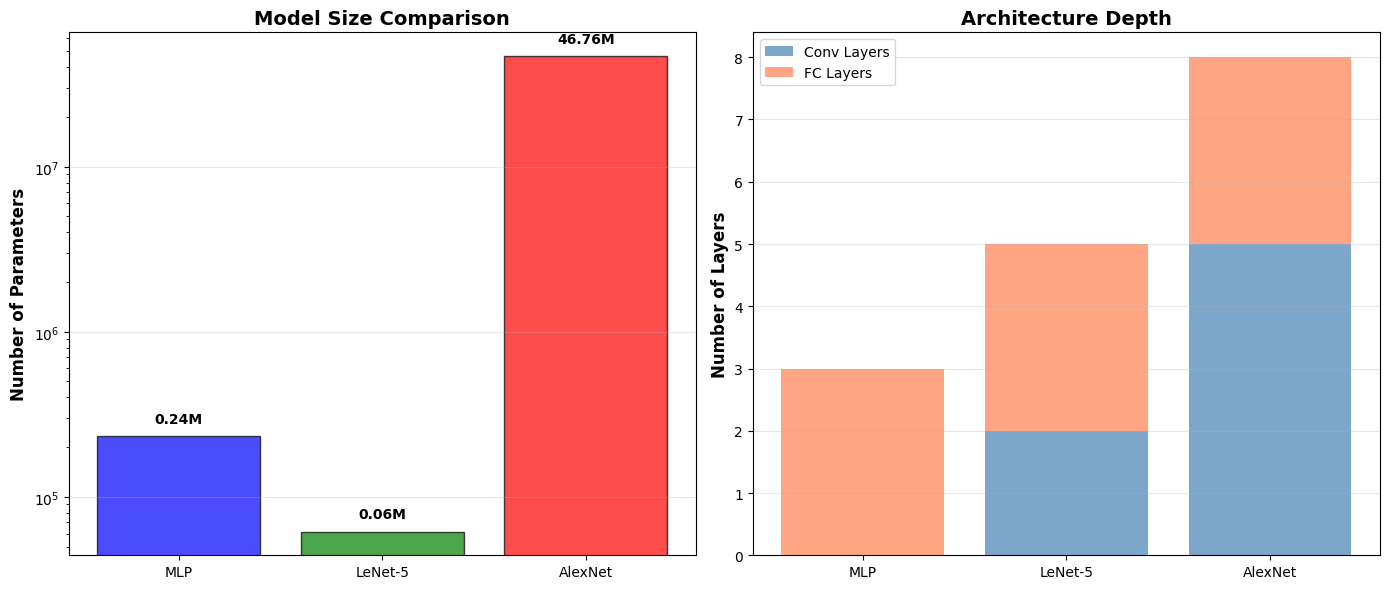


Model           Parameters      Conv Layers     FC Layers
MLP                  235,146              0            3
LeNet-5               61,706              2            3
AlexNet           46,764,746              5            3


In [38]:
# ==========================================
# 7.2 Visualizing Model Size & Depth
# ==========================================
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Build a specific MLP for this comparison (matches the graph requirements)
class MLP_Comparison(nn.Module):
    def __init__(self):
        super(MLP_Comparison, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

mlp_comp = MLP_Comparison()

# Compare parameters
# We use the models we defined/trained earlier, plus this specific MLP
models = {
    'MLP': mlp_comp,
    'LeNet-5': lenet.cpu(),
    'AlexNet': alexnet.cpu()
}

results_param = {}
for name, model in models.items():
    params = sum(p.numel() for p in model.parameters())
    results_param[name] = params

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 1. Parameter count
names = list(results_param.keys())
params = list(results_param.values())
colors = ['blue', 'green', 'red']

ax1.bar(names, params, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Number of Parameters', fontsize=12, fontweight='bold')
ax1.set_title('Model Size Comparison', fontsize=14, fontweight='bold')
ax1.set_yscale('log') # Log scale to handle the massive difference
ax1.grid(True, axis='y', alpha=0.3)

for i, (name, param) in enumerate(zip(names, params)):
    ax1.text(i, param * 1.2, f'{param/1e6:.2f}M', ha='center', fontweight='bold')

# 2. Architecture comparison (Depth)
arch_info = {
    'MLP': {'Conv Layers': 0, 'FC Layers': 3},
    'LeNet-5': {'Conv Layers': 2, 'FC Layers': 3},
    'AlexNet': {'Conv Layers': 5, 'FC Layers': 3}
}

x_pos = np.arange(len(names))
conv_counts = [arch_info[n]['Conv Layers'] for n in names]
fc_counts = [arch_info[n]['FC Layers'] for n in names]

ax2.bar(x_pos, conv_counts, label='Conv Layers', color='steelblue', alpha=0.7)
ax2.bar(x_pos, fc_counts, bottom=conv_counts, label='FC Layers', color='coral', alpha=0.7)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(names)
ax2.set_ylabel('Number of Layers', fontsize=12, fontweight='bold')
ax2.set_title('Architecture Depth', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*70)
print(f"{'Model':<15} {'Parameters':<15} {'Conv Layers':<15} {'FC Layers'}")
print("="*70)
for name in names:
    print(f"{name:<15} {results_param[name]:>12,}   {arch_info[name]['Conv Layers']:>12}   {arch_info[name]['FC Layers']:>10}")
print("="*70)



In [39]:
# ==========================================
# 7.3 Detailed Architecture Comparison
# ==========================================
comparison = {
    'Aspect': [
        'Year',
        'Total Layers',
        'Conv Layers',
        'FC Layers',
        'First Conv Kernel',
        'Activation',
        'Pooling',
        'Regularization',
        'Total Parameters',
        'Conv Parameters',
        'FC Parameters',
        'Input Size',
        'Dataset'
    ],
    'LeNet-5': [
        '1998',
        '7 (2 conv + 3 FC + 2 pool)',
        '2',
        '3',
        '5×5',
        'Sigmoid',
        'Average Pooling',
        'None',
        '~60K',
        '~3K',
        '~57K',
        '28×28 (grayscale)',
        'MNIST (60K images)'
    ],
    'AlexNet': [
        '2012',
        '8 (5 conv + 3 FC)',
        '5',
        '3',
        '11×11, stride=4',
        'ReLU',
        'Max Pooling',
        'Dropout (0.5)',
        '~46M',
        '~2.3M',
        '~43.7M',
        '224×224 (RGB)',
        'ImageNet (1.2M images)'
    ]
}

print("\n" + "="*100)
print("LeNet-5 vs AlexNet: Complete Comparison")
print("="*100)
print(f"{'Aspect':<25} {'LeNet-5':<35} {'AlexNet':<35}")
print("="*100)

for i, aspect in enumerate(comparison['Aspect']):
    print(f"{aspect:<25} {comparison['LeNet-5'][i]:<35} {comparison['AlexNet'][i]:<35}")

print("="*100)

print("\n💡 Key Architectural Differences:\n")
print("1. DEPTH:")
print("   • LeNet: 2 conv layers (shallow)")
print("   • AlexNet: 5 conv layers (deep)")
print("   • Impact: Deeper networks learn more complex hierarchical features\n")

print("2. FILTER SIZE:")
print("   • LeNet: 5×5 kernels throughout")
print("   • AlexNet: Large 11×11 first layer, then 5×5, then 3×3")
print("   • Impact: Large kernels capture broader context initially\n")

print("3. LAYER ARRANGEMENT:")
print("   • LeNet: Conv→Pool→Conv→Pool→FC→FC→FC")
print("   • AlexNet: Conv→Pool→Conv→Pool→Conv→Conv→Conv→Pool→FC→FC→FC")
print("   • Impact: More conv layers before pooling = richer features\n")

print("4. PERFORMANCE IMPACT:")
print("   • LeNet: ~99% on MNIST (simple dataset)")
print("   • AlexNet: Won ImageNet 2012 (complex, large-scale dataset)")
print("   • Impact: Depth + modern techniques = breakthrough performance")




LeNet-5 vs AlexNet: Complete Comparison
Aspect                    LeNet-5                             AlexNet                            
Year                      1998                                2012                               
Total Layers              7 (2 conv + 3 FC + 2 pool)          8 (5 conv + 3 FC)                  
Conv Layers               2                                   5                                  
FC Layers                 3                                   3                                  
First Conv Kernel         5×5                                 11×11, stride=4                    
Activation                Sigmoid                             ReLU                               
Pooling                   Average Pooling                     Max Pooling                        
Regularization            None                                Dropout (0.5)                      
Total Parameters          ~60K                                ~46M           

# 8. Exercises

Try these to deepen your understanding:

### LeNet:
1. Replace average pooling with max pooling. What happens?
2. Replace sigmoid with ReLU activations. How does performance change?
3. Try deeper networks: add more convolutional layers

### AlexNet:
4. Remove dropout from AlexNet. Does it overfit?
5. Change the learning rate. What's optimal for AlexNet?
6. AlexNet is too large for Fashion-MNIST. Simplify it while maintaining accuracy.

### Parameter Analysis:
7. Calculate by hand the parameters in the first conv layer of AlexNet
8. Why do AlexNet's FC layers have so many parameters? How could we reduce them?
9. Design a CNN with <100K parameters that achieves >85% on Fashion-MNIST

## 9. Final Conclusion & Analysis

In this notebook, we explored the evolution from MLPs to CNNs.

### Key Takeaways:
1.  **MLP vs CNN**: The **SimpleCNN** should have outperformed the **MLP**. Why? Because the MLP destroys the spatial structure of the image by flattening it immediately. The CNN preserves this structure, allowing it to learn features like "edges" and "curves" regardless of where they appear in the image (Translation Invariance).
2.  **Efficiency**: **LeNet** is incredibly efficient. It achieves decent accuracy with very few parameters. This makes it ideal for resource-constrained environments (like early 90s hardware or embedded systems).
3.  **Depth Matters**: **AlexNet** shows that going deeper (more layers) and wider (more filters) allows the network to learn more complex representations, but at the cost of massive computation and memory usage.